In [1]:
import torch

from torch.distributions.beta import Beta

In [2]:
x = (Beta(1.0, 1).sample() * 256)
print(x)
print(x.round())

tensor(175.9902)
tensor(176.)


In [3]:
round(45.6)

46

In [4]:

def _in_range(x, min_seq, max_seq):
    return (x >= min_seq) and (x <= max_seq)


def _break_stick(x, alpha, beta, min_seq, max_seq):
    if _in_range(x, min_seq, max_seq):
        return [x]
    split1, split2 = 0, 0
    while (split1 < min_seq) or (split2 < min_seq):
        split1 = (x * Beta(alpha, beta).sample()).round().item()
        split2 = x - split1
    return _break_stick(split1, alpha, beta, min_seq, max_seq) + _break_stick(split2, alpha, beta, min_seq, max_seq)
    
    
def stick_breaking(ctx_len: int, min_seq_len: int):
    raise NotImplementedError

In [5]:
import polars as pl

In [44]:
sticks = [_break_stick(256, 1.0, 1.0, 5, 20) for _ in range(1000)]
df = pl.DataFrame([{'num_seqs': len(s), 'seq_lens': tuple(s)} for s in sticks])

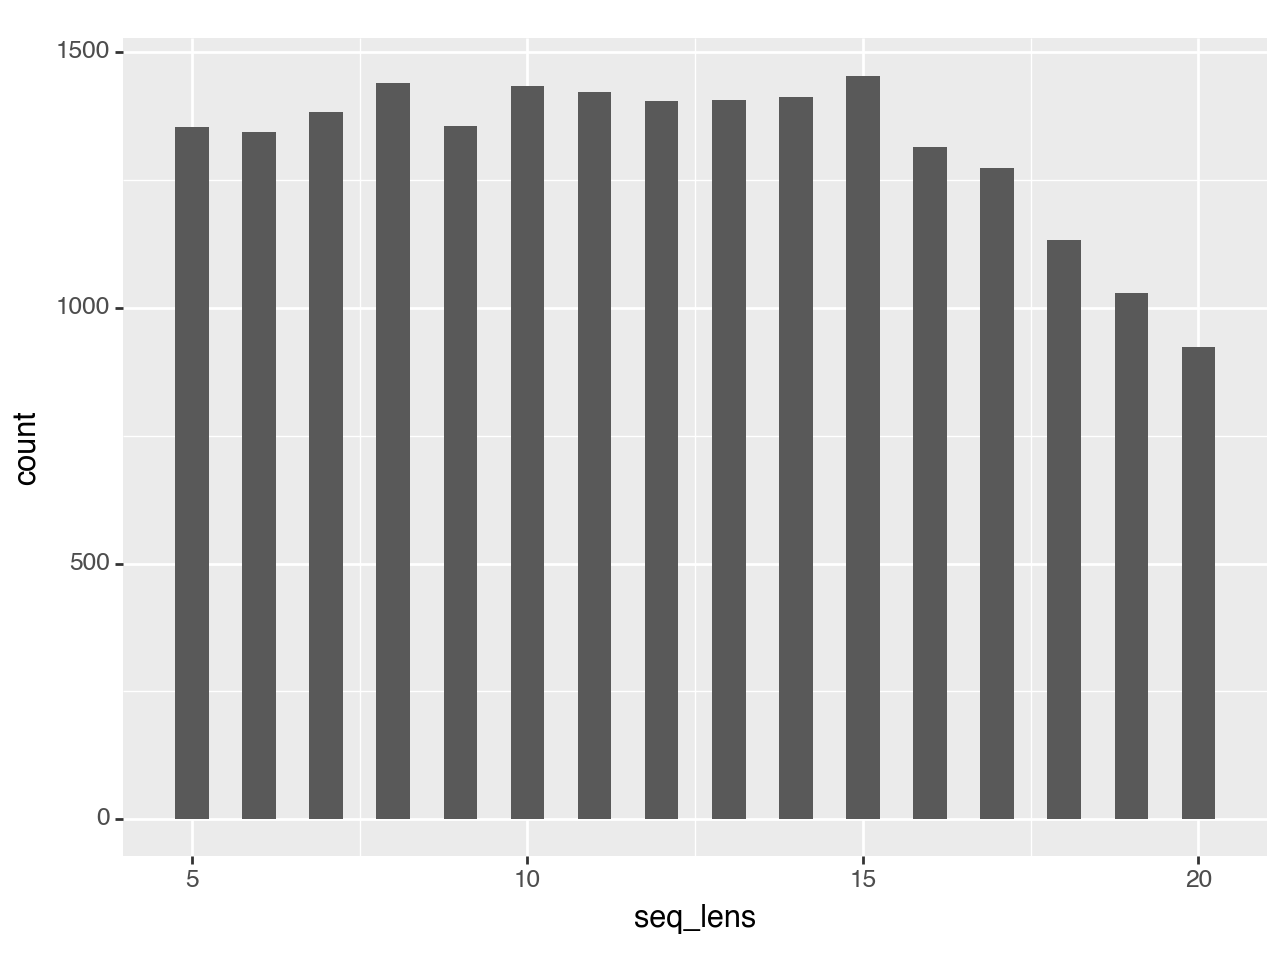

<Figure Size: (640 x 480)>

In [45]:
from plotnine import ggplot, aes, geom_histogram



ggplot(df.explode('seq_lens'), aes(x='seq_lens')) + geom_histogram(binwidth=0.5)

In [54]:
import numpy as np

rng = np.random.default_rng()


seq_lens = rng.integers(5, 20, 200)
cum_lengths = np.cumsum(seq_lens)
print(cum_lengths)
seq_lens[cum_lengths <= 256].tolist()

[  13   32   43   52   70   88   99  111  118  125  136  142  148  161
  168  175  194  203  213  221  236  249  262  271  283  293  308  315
  324  335  353  360  369  385  398  403  415  433  449  468  481  487
  493  501  508  514  532  546  564  574  579  589  595  601  613  619
  636  645  659  676  686  701  716  721  735  747  766  772  789  801
  814  832  838  847  855  873  892  904  912  928  940  953  968  981
  988 1004 1010 1019 1029 1042 1055 1062 1068 1080 1087 1097 1116 1135
 1146 1156 1172 1188 1207 1215 1231 1238 1256 1267 1281 1287 1296 1311
 1325 1340 1358 1364 1375 1392 1403 1421 1436 1447 1456 1469 1479 1484
 1491 1503 1516 1527 1532 1546 1563 1575 1586 1592 1600 1618 1627 1641
 1659 1665 1682 1694 1703 1716 1724 1739 1752 1763 1769 1788 1801 1816
 1832 1842 1860 1871 1889 1907 1919 1934 1953 1968 1982 1999 2011 2026
 2040 2050 2060 2070 2084 2090 2101 2106 2121 2133 2148 2162 2168 2174
 2181 2190 2201 2211 2230 2240 2256 2273 2279 2296 2301 2310 2315 2324
 2338 

[13, 19, 11, 9, 18, 18, 11, 12, 7, 7, 11, 6, 6, 13, 7, 7, 19, 9, 10, 8, 15, 13]

In [75]:
for i in range(10000):
    x = get_seq_lengths(512, 5, 50)
    assert sum(x) == 512

In [88]:
sep

array([3])

In [89]:
np.full((3,), sep)

array([3, 3, 3])

In [87]:
x = rng.integers(0, 2, 3)
running_x = np.cumsum(x) % 2



array([3, 0, 1, 1, 2, 0, 1, 0])

In [235]:

def get_seq_lengths(total_length, min_length, max_length, rng):
    too_many = rng.integers(min_length, max_length, min_length * total_length)
    sequence_lengths = too_many[np.cumsum(too_many) <= total_length]
    diff = total_length - np.sum(sequence_lengths)
    sequence_lengths = sequence_lengths.tolist()
    if diff >= min_length and diff <= max_length:
        sequence_lengths += [diff]
    return sequence_lengths
    

def generate_cum_parity(total_seq_len: int, rng):
    seq_len = (total_seq_len - 2) // 2
    assert seq_len > 0, total_seq_len
    equals = np.array([2])
    sep = 3
    x = rng.integers(0, 2, seq_len)
    running_x = np.cumsum(x) % 2
    seq = np.concatenate([x, equals, running_x], axis=0)
    seq = np.pad(seq, (1, total_seq_len - len(seq) - 1), mode='constant', constant_values=(sep, sep))
    return seq


def generate_packed_parity(total_seq_length, min_seq_length=6, max_seq_length=30, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    sep = 3
    sequence_lengths = get_seq_lengths(total_seq_length, min_seq_length, max_seq_length, rng)
    assert sum(sequence_lengths) <= total_seq_length
    parities = [
            generate_cum_parity(seq_len, stream) for seq_len, stream in zip(sequence_lengths, rng.spawn(len(sequence_lengths)))
    ]
    parities = np.concatenate(parities)
    diff = total_seq_length - len(parities)
    return np.pad(parities, (0, diff), mode='constant', constant_values=(sep, sep))
          




In [236]:
print(len(generate_packed_parity(512, 8, 32, rng)))

512


In [240]:
parities = [ generate_packed_parity(512, 8, 32, stream) for stream in rng.spawn(1024)]
np.stack(parities, axis=0)

array([[3, 0, 0, ..., 1, 1, 0],
       [3, 0, 1, ..., 1, 1, 3],
       [3, 0, 1, ..., 1, 1, 3],
       ...,
       [3, 1, 0, ..., 1, 0, 3],
       [3, 0, 1, ..., 0, 1, 3],
       [3, 1, 0, ..., 1, 0, 0]])